<a href="https://colab.research.google.com/github/mfyuce/deep-learning-with-python-notebooks/blob/master/chapter04_classification-and-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Third Edition](https://www.manning.com/books/deep-learning-with-python-third-edition). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

The book's contents are available online at [deeplearningwithpython.io](https://deeplearningwithpython.io).

In [67]:
!pip install keras keras-hub --upgrade -q

In [68]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [69]:
# @title
import os
from IPython.core.magic import register_cell_magic

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

## Classification and regression

### Classifying movie reviews: A binary classification example

#### The IMDb dataset

In [70]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000
)

In [71]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [72]:
train_labels[0]

np.int64(1)

In [73]:
max([max(sequence) for sequence in train_data])

9999

In [74]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]]
)

In [75]:
decoded_review[:100]

"? this film was just brilliant casting location scenery story direction everyone's really suited the"

#### Preparing the data

In [76]:
import numpy as np

def multi_hot_encode(sequences, num_classes):
    results = np.zeros((len(sequences), num_classes))
    for i, sequence in enumerate(sequences):
        results[i][sequence] = 1.0
    return results

x_train = multi_hot_encode(train_data, num_classes=10000)
x_test = multi_hot_encode(test_data, num_classes=10000)

In [77]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [78]:
y_train = train_labels.astype("float32")
y_test = test_labels.astype("float32")

#### Building your model

In [79]:
import keras
from keras import layers

model = keras.Sequential(
    [
        layers.Dense(16, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

In [80]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

#### Validating your approach

In [81]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [82]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val),
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.6031 - loss: 0.6281 - val_accuracy: 0.7981 - val_loss: 0.5457
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8624 - loss: 0.4499 - val_accuracy: 0.8746 - val_loss: 0.3844
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9231 - loss: 0.2785 - val_accuracy: 0.8906 - val_loss: 0.2948
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9439 - loss: 0.1881 - val_accuracy: 0.8895 - val_loss: 0.2792
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9593 - loss: 0.1389 - val_accuracy: 0.8879 - val_loss: 0.2844
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9721 - loss: 0.1064 - val_accuracy: 0.8847 - val_loss: 0.2993
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9833 - loss: 0.0801 - val_accuracy: 0.8817 - val_loss: 0.3211
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9896 - loss: 0.0608 - val_accuracy: 0.8784 - 

In [83]:
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.2,
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9299 - loss: 0.2430 - val_accuracy: 0.9748 - val_loss: 0.0807
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9620 - loss: 0.1141 - val_accuracy: 0.9728 - val_loss: 0.0787
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9798 - loss: 0.0727 - val_accuracy: 0.9686 - val_loss: 0.0896
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9893 - loss: 0.0465 - val_accuracy: 0.9602 - val_loss: 0.1033
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9952 - loss: 0.0328 - val_accuracy: 0.9556 - val_loss: 0.1184
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9973 - loss: 0.0227 - val_accuracy: 0.9524 - val_loss: 0.1246
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9984 - loss: 0.0160 - val_accuracy: 0.9506 - val_loss: 0.1352
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9988 - loss: 0.0119 - val_accuracy: 0.9498 - v

In [84]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

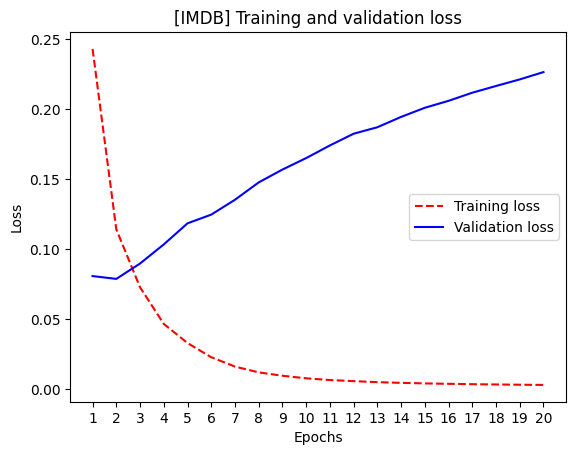

In [85]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r--", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("[IMDB] Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

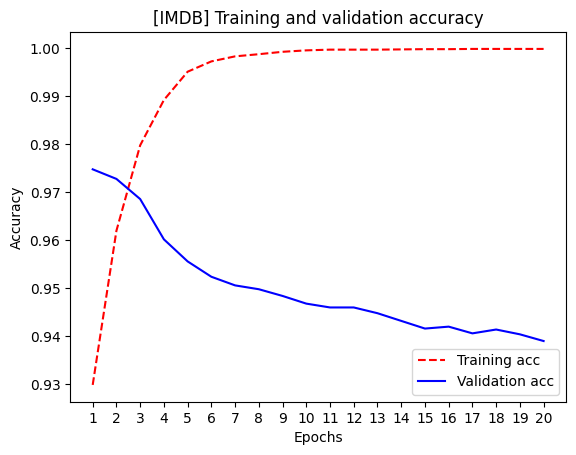

In [86]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "r--", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("[IMDB] Training and validation accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [87]:
model = keras.Sequential(
    [
        layers.Dense(16, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8099 - loss: 0.4739
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9139 - loss: 0.2430
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9375 - loss: 0.1805
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9504 - loss: 0.1454
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8790 - loss: 0.3121


In [88]:
results

[0.31208518147468567, 0.8789599537849426]

#### Using a trained model to generate predictions on new data

In [89]:
model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


array([[0.18820001],
       [0.9997722 ],
       [0.8044816 ],
       ...,
       [0.11061492],
       [0.08611568],
       [0.7943789 ]], dtype=float32)

#### Further experiments

#### Wrapping up

### Classifying newswires: A multiclass classification example

#### The Reuters dataset

In [90]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000
)

In [91]:
len(train_data)

8982

In [92]:
len(test_data)

2246

In [93]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [94]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[10]]
)

In [95]:
train_labels[10]

np.int64(3)

#### Preparing the data

In [96]:
x_train = multi_hot_encode(train_data, num_classes=10000)
x_test = multi_hot_encode(test_data, num_classes=10000)

In [97]:
def one_hot_encode(labels, num_classes=46):
    results = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        results[i, label] = 1.0
    return results

y_train = one_hot_encode(train_labels)
y_test = one_hot_encode(test_labels)

In [98]:
from keras.utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

#### Building your model

In [99]:
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(46, activation="softmax"),
    ]
)

In [100]:
top_3_accuracy = keras.metrics.TopKCategoricalAccuracy(
    k=3, name="top_3_accuracy"
)
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", top_3_accuracy],
)

#### Validating your approach

In [101]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [102]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val),
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.3265 - loss: 3.2245 - top_3_accuracy: 0.5653 - val_accuracy: 0.3600 - val_loss: 2.4912 - val_top_3_accuracy: 0.6660
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5390 - loss: 2.0148 - top_3_accuracy: 0.6956 - val_accuracy: 0.6250 - val_loss: 1.6984 - val_top_3_accuracy: 0.7230
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6834 - loss: 1.4401 - top_3_accuracy: 0.7831 - val_accuracy: 0.6920 - val_loss: 1.3731 - val_top_3_accuracy: 0.7870
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7504 - loss: 1.1207 - top_3_accuracy: 0.8452 - val_accuracy: 0.7360 - val_loss: 1.1925 - val_top_3_accuracy: 0.8440
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8034 - loss: 0.8956 - top_3_accuracy: 0.8871 - val_accuracy: 0.7710 - val_loss: 1.0806 - val_top_3_accuracy: 0.8680
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8500 - loss: 0.7048 - top_3_a

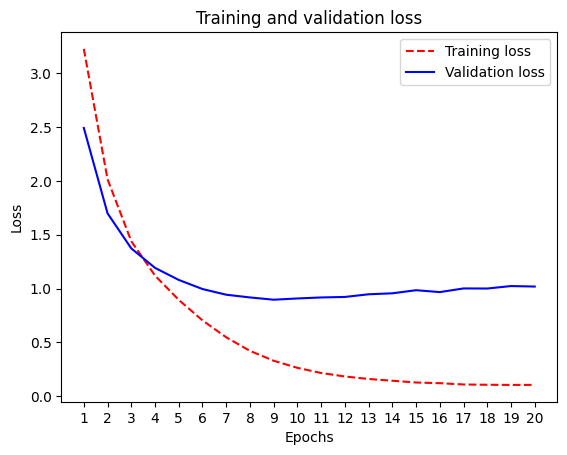

In [103]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

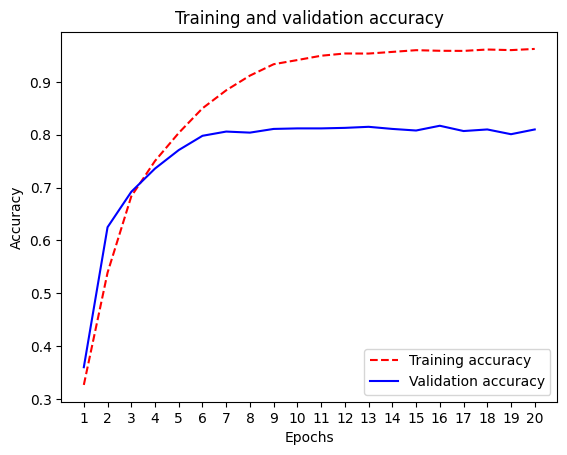

In [104]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "r--", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

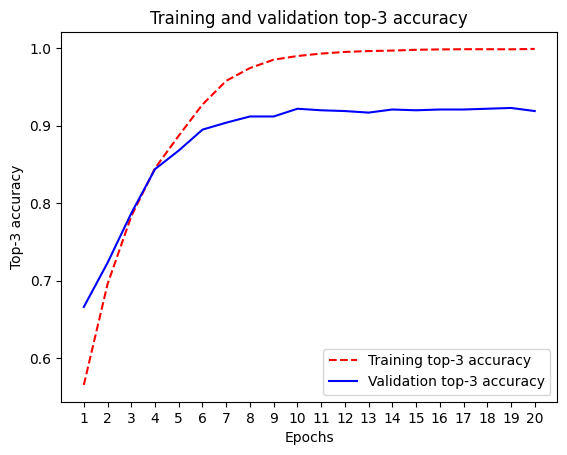

In [105]:
plt.clf()
acc = history.history["top_3_accuracy"]
val_acc = history.history["val_top_3_accuracy"]
plt.plot(epochs, acc, "r--", label="Training top-3 accuracy")
plt.plot(epochs, val_acc, "b", label="Validation top-3 accuracy")
plt.title("Training and validation top-3 accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Top-3 accuracy")
plt.legend()
plt.show()

In [106]:
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(46, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    x_train,
    y_train,
    epochs=9,
    batch_size=512,
)
results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.4538 - loss: 3.3279
Epoch 2/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6286 - loss: 1.9719
Epoch 3/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7260 - loss: 1.2953
Epoch 4/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7910 - loss: 0.9772
Epoch 5/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8408 - loss: 0.7605
Epoch 6/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8785 - loss: 0.5879
Epoch 7/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9071 - loss: 0.4572
Epoch 8/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9253 - loss: 0.3571
Epoch 9/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9384 - loss: 0.2875
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7907 - loss: 0.9314


In [107]:
results

[0.9313610792160034, 0.790739119052887]

In [108]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels == test_labels_copy)
hits_array.mean()

np.float64(0.18655387355298308)

#### Generating predictions on new data

In [109]:
predictions = model.predict(x_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [110]:
predictions[0].shape

(46,)

In [111]:
np.sum(predictions[0])

np.float32(0.99999994)

In [112]:
np.argmax(predictions[0])

np.int64(3)

#### A different way to handle the labels and the loss

In [113]:
y_train = train_labels
y_test = test_labels

In [114]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

#### The importance of having sufficiently large intermediate layers

In [115]:
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(4, activation="relu"),
        layers.Dense(46, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_val, y_val),
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2674 - loss: 3.2288 - val_accuracy: 0.4030 - val_loss: 2.4202
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5636 - loss: 1.8341 - val_accuracy: 0.6030 - val_loss: 1.5779
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6254 - loss: 1.3968 - val_accuracy: 0.6330 - val_loss: 1.4587
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6719 - loss: 1.2281 - val_accuracy: 0.6510 - val_loss: 1.3987
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7055 - loss: 1.1130 - val_accuracy: 0.6600 - val_loss: 1.3900
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7212 - loss: 1.0302 - val_accuracy: 0.6590 - val_loss: 1.3875
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7316 - loss: 0.9613 - val_accuracy: 0.6630 - val_loss: 1.4003
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7494 - loss: 0.9056 - val_accuracy: 0.6580 - val_loss

#### Further experiments

#### Wrapping up

### Predicting house prices: A regression example

#### The California Housing Price dataset

In [116]:
from keras.datasets import california_housing

(train_data, train_targets), (test_data, test_targets) = (
    california_housing.load_data(version="small")
)

In [117]:
train_data.shape

(480, 8)

In [118]:
test_data.shape

(120, 8)

In [119]:
train_targets

array([228400., 132900.,  60000.,  95200., 107000., 122500., 132000.,
       290100., 257800., 390100., 220800., 284900.,  97500., 415300.,
        84200., 185600., 216700., 233100., 127000., 182300.,  92300.,
        90700., 102100., 112500., 350700., 156500., 220700., 147400.,
       216700., 275000., 198200., 119100., 289500., 152500., 125000.,
       104500.,  93800.,  89300., 452600., 128600., 311500.,  90000.,
       218200., 131300.,  67500., 139400., 500001., 182600., 111300.,
       112500., 134700.,  71300., 207400., 331400., 107900.,  87500.,
       342200.,  87100., 314700., 368600., 211600., 338900., 366100.,
       164300.,  91700., 261400., 218500., 155400., 273700.,  81800.,
       138800.,  99700., 156300., 140600., 152700., 108900., 351200.,
       126000., 137500., 196900., 240000., 172800., 254200.,  97500.,
       182700., 162500.,  86100., 226700., 412500., 165900., 327100.,
       162500., 188800., 183800.,  90600., 372000., 275000., 151800.,
       125000., 1291

#### Preparing the data

In [120]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
x_train = (train_data - mean) / std
x_test = (test_data - mean) / std

In [121]:
y_train = train_targets / 100000
y_test = test_targets / 100000

#### Building your model

In [122]:
def get_model():
    model = keras.Sequential(
        [
            layers.Dense(64, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(1),
        ]
    )
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model

#### Validating your approach using K-fold validation

In [123]:
k = 4
num_val_samples = len(x_train) // k
num_epochs = 50
all_scores = []
for i in range(k):
    print(f"Processing fold #{i + 1}")
    fold_x_val = x_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_y_val = y_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_x_train = np.concatenate(
        [x_train[: i * num_val_samples], x_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    fold_y_train = np.concatenate(
        [y_train[: i * num_val_samples], y_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    model = get_model()
    model.fit(
        fold_x_train,
        fold_y_train,
        epochs=num_epochs,
        batch_size=16,
        verbose=0,
    )
    scores = model.evaluate(fold_x_val, fold_y_val, verbose=0)
    val_loss, val_mae = scores
    all_scores.append(val_mae)

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [124]:
[round(value, 3) for value in all_scores]

[0.32, 0.289, 0.244, 0.308]

In [125]:
round(np.mean(all_scores), 3)

np.float64(0.291)

In [126]:
k = 4
num_val_samples = len(x_train) // k
num_epochs = 200
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i + 1}")
    fold_x_val = x_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_y_val = y_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_x_train = np.concatenate(
        [x_train[: i * num_val_samples], x_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    fold_y_train = np.concatenate(
        [y_train[: i * num_val_samples], y_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    model = get_model()
    history = model.fit(
        fold_x_train,
        fold_y_train,
        validation_data=(fold_x_val, fold_y_val),
        epochs=num_epochs,
        batch_size=16,
        verbose=0,
    )
    mae_history = history.history["val_mean_absolute_error"]
    all_mae_histories.append(mae_history)

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [127]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

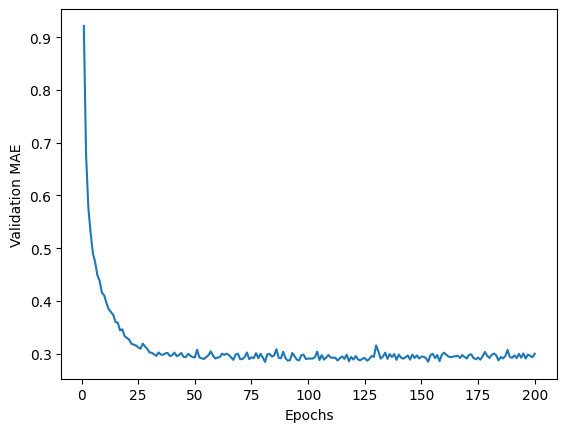

In [128]:
epochs = range(1, len(average_mae_history) + 1)
plt.plot(epochs, average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

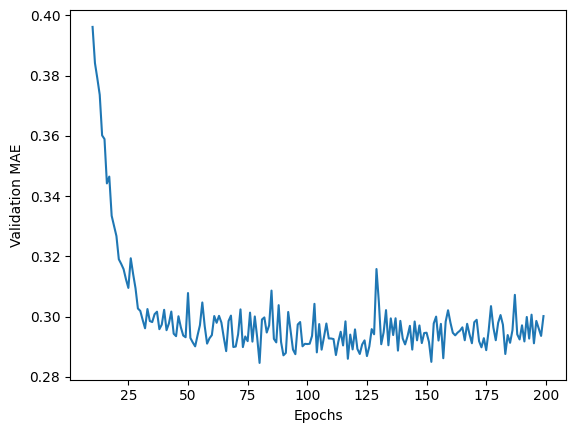

In [129]:
truncated_mae_history = average_mae_history[10:]
epochs = range(10, len(truncated_mae_history) + 10)
plt.plot(epochs, truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [130]:
model = get_model()
model.fit(x_train, y_train, epochs=130, batch_size=16, verbose=0)
test_mean_squared_error, test_mean_absolute_error = model.evaluate(
    x_test, y_test
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2982 - mean_absolute_error: 0.3111


In [131]:
round(test_mean_absolute_error, 3)

0.311

#### Generating predictions on new data

In [132]:
predictions = model.predict(x_test)
predictions[0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([2.605028], dtype=float32)

#### Wrapping up